TODO: check initialization of sindy coefficient matrix

In [ ]:
import torch
import numpy as np
import math
import torch.nn.functional as F
import json
import dill
import matplotlib.pyplot as plt
# from torchdiffeq import odeint
from tqdm import tqdm
from scipy.integrate import odeint
from scipy.special import legendre
from itertools import combinations_with_replacement
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## SINDy Utils

In [ ]:
def sindy_library_strings(latent_dim, poly_order, include_sine=False, order=2):
    """
    Returns a list of string representations for each basis function in the SINDy library.

    Args:
        latent_dim (int): Number of latent variables (dimensions).
        poly_order (int): Maximum degree of polynomial terms to include.
        include_sine (bool): Whether to include sine terms.
        order (int): 1 for first-order, 2 for second-order systems.

    Returns:
        List[str]: A list of human-readable strings for each basis function.
    """
    assert order in [1, 2], "Only first or second order systems are supported."

    basis_strings = ["1"]  # Constant term
    z_names = [f"z{i}" for i in range(latent_dim)]

    if order == 1:
        var_names = z_names
    elif order == 2:
        dz_names = [f"dz{i}" for i in range(latent_dim)]
        var_names = z_names + dz_names

    var_indices = list(range(len(var_names)))

    # Polynomial terms
    for n in range(1, poly_order + 1):
        combos = combinations_with_replacement(var_indices, n)
        for combo in combos:
            powers = {}
            for idx in combo:
                powers[idx] = powers.get(idx, 0) + 1

            term_str = " * ".join(
                f"{var_names[i]}^{p}" if p > 1 else var_names[i]
                for i, p in powers.items()
            )
            basis_strings.append(term_str)

    # Sine terms (optional)
    if include_sine:
        for name in var_names:
            basis_strings.append(f"sin({name})")

    return basis_strings

def sindy_library_pt(z, latent_dim, poly_order, include_sine=False):
    """
    Description: Builds the SINDy library for a first-order dynamical system.

    Args:
        z (torch.Tensor): Input tensor of shape (batch_size, latent_dim), representing latent states.
        latent_dim (int): Number of latent variables (dimensions).
        poly_order (int): Maximum degree of polynomial terms to include in the library.
        include_sine (bool): Whether to include sine terms in the library.

    Returns:
        torch.Tensor: A matrix (batch_size, library_size) where each column is a function of z.
    """

    # Initialize the library with a column of ones. The number of rows is equal to batch size.
    library = [torch.ones(z.size(0)).to(device)]

    # Prepare to loop over all variable combinations
    sample_list = range(latent_dim)

    for n in range(1, poly_order + 1):
        # Get all combinations (with replacement) of latent_dim variables of total degree n
        list_combinations = list(combinations_with_replacement(sample_list, n))

        for combination in list_combinations:
            # For each combination, compute the product of the corresponding columns in z
            # e.g., z[:, [0, 0]] -> z_0^2, z[:, [1, 2]] -> z_1 * z_2
            term = torch.prod(z[:, combination], dim=1)
            library.append(term.to(device))  # Add to the library (on GPU)

    # Optionally add sine terms of each latent variable
    if include_sine:
        for i in range(latent_dim):
            library.append(
                torch.sin(z[:, i])
            )  # Automatically on correct device since z is

    # Stack all features column-wise into a single tensor of shape (batch_size, num_features)
    return torch.stack(library, dim=1).to(device)

def sindy_library(X, poly_order, include_sine=False):
    m, n = X.shape
    l = library_size(n, poly_order, include_sine)
    library = np.ones((m, l))
    index = 1

    for i in range(n):
        library[:, index] = X[:, i]
        index += 1

    if poly_order > 1:
        for i in range(n):
            for j in range(i, n):
                library[:, index] = X[:, i] * X[:, j]
                index += 1

    if poly_order > 2:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    library[:, index] = X[:, i] * X[:, j] * X[:, k]
                    index += 1

    if poly_order > 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for q in range(k, n):
                        library[:, index] = X[:, i] * X[:, j] * X[:, k] * X[:, q]
                        index += 1

    if poly_order > 4:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for q in range(k, n):
                        for r in range(q, n):
                            library[:, index] = (
                                X[:, i] * X[:, j] * X[:, k] * X[:, q] * X[:, r]
                            )
                            index += 1

    if include_sine:
        for i in range(n):
            library[:, index] = np.sin(X[:, i])
            index += 1

    return library

def sindy_library_pt_order2(z, dz, latent_dim, poly_order, include_sine=False):
    """
    Build the SINDy library for a second-order system.
    """
    library = [torch.ones(z.size(0)).to(device)]  # initialize library

    # concatenate z and dz
    z_combined = torch.cat([z, dz], dim=1)

    sample_list = range(2 * latent_dim)
    list_combinations = list()

    for n in range(1, poly_order + 1):
        list_combinations = list(combinations_with_replacement(sample_list, n))
        for combination in list_combinations:
            library.append(
                torch.prod(z_combined[:, combination], dim=1).to(device)
            )

    # add sine terms if included
    if include_sine:
        for i in range(2 * latent_dim):
            library.append(torch.sin(z_combined[:, i]))

    return torch.stack(library, dim=1).to(device)


def library_size(latent_dim, poly_order, include_sine=False):
    def f(d, k):
        return math.comb(d + k - 1, k)

    total = 0
    for i in range(poly_order + 1):
        total += f(latent_dim, i)

    if include_sine:
        total += latent_dim  # Add one sine term per latent variable

    return total

def sindy_simulate(x0, t, Xi, poly_order, include_sine):
    m = t.size
    n = x0.size
    f = lambda x, t: np.dot(
        sindy_library(np.array(x).reshape((1, n)), poly_order, include_sine), Xi
    ).reshape((n,))

    x = odeint(f, x0, t)
    return x


def sindy_simulate_order2(x0, dx0, t, Xi, poly_order, include_sine):
    m = t.size
    n = 2 * x0.size
    l = Xi.shape[0]

    Xi_order1 = np.zeros((l, n))
    for i in range(Xi.shape[1]):  # safer and clearer
      Xi_order1[2 * (i + 1), i] = 1.0
      Xi_order1[:, i + n // 2] = Xi[:, i]

    x = sindy_simulate(
        np.concatenate((x0, dx0)), t, Xi_order1, poly_order, include_sine
    )
    return x

# Generate data

## Lorenz

### Lorenz Code

In [ ]:
def get_lorenz_data(n_ics, noise_strength=0):
    """
    Generate a set of Lorenz training data for multiple random initial conditions.

    Arguments:
        n_ics - Integer specifying the number of initial conditions to use.
        noise_strength - Amount of noise to add to the data.

    Return:
        data - Dictionary containing elements of the dataset. See generate_lorenz_data()
        doc string for list of contents.
    """
    t = np.arange(0, 5, 0.02)
    n_steps = t.size
    input_dim = 128

    ic_means = np.array([0, 0, 25])
    ic_widths = 2 * np.array([36, 48, 41])

    # training data
    ics = ic_widths * (np.random.rand(n_ics, 3) - 0.5) + ic_means
    data = generate_lorenz_data(
        ics,
        t,
        input_dim,
        linear=False,
        normalization=np.array([1 / 40, 1 / 40, 1 / 40]),
    )
    data["x"] = data["x"].reshape((-1, input_dim)) + noise_strength * np.random.randn(
        n_steps * n_ics, input_dim
    )
    data["dx"] = data["dx"].reshape((-1, input_dim)) + noise_strength * np.random.randn(
        n_steps * n_ics, input_dim
    )
    data["ddx"] = data["ddx"].reshape(
        (-1, input_dim)
    ) + noise_strength * np.random.randn(n_steps * n_ics, input_dim)

    return data

def simulate_lorenz(z0, t, sigma=10.0, beta=8 / 3, rho=28.0):
    """
    Simulate the Lorenz dynamics.

    Arguments:
        z0 - Initial condition in the form of a 3-value list or array.
        t - Array of time points at which to simulate.
        sigma, beta, rho - Lorenz parameters

    Returns:
        z, dz, ddz - Arrays of the trajectory values and their 1st and 2nd derivatives.
    """
    f = lambda z, t: [
        sigma * (z[1] - z[0]),
        z[0] * (rho - z[2]) - z[1],
        z[0] * z[1] - beta * z[2],
    ]
    df = lambda z, dz, t: [
        sigma * (dz[1] - dz[0]),
        dz[0] * (rho - z[2]) + z[0] * (-dz[2]) - dz[1],
        dz[0] * z[1] + z[0] * dz[1] - beta * dz[2],
    ]

    z = odeint(f, z0, t)

    dt = t[1] - t[0]
    dz = np.zeros(z.shape)
    ddz = np.zeros(z.shape)
    for i in range(t.size):
        dz[i] = f(z[i], dt * i)
        ddz[i] = df(z[i], dz[i], dt * i)
    return z, dz, ddz

def lorenz_coefficients(normalization, poly_order=3, sigma=10.0, beta=8 / 3, rho=28.0):
    """
    Generate the SINDy coefficient matrix for the Lorenz system.

    Arguments:
        normalization - 3-element list of array specifying scaling of each Lorenz variable
        poly_order - Polynomial order of the SINDy model.
        sigma, beta, rho - Parameters of the Lorenz system
    """
    Xi = np.zeros((library_size(3, poly_order), 3))
    Xi[1, 0] = -sigma
    Xi[2, 0] = sigma * normalization[0] / normalization[1]
    Xi[1, 1] = rho * normalization[1] / normalization[0]
    Xi[2, 1] = -1
    Xi[6, 1] = -normalization[1] / (normalization[0] * normalization[2])
    Xi[3, 2] = -beta
    Xi[5, 2] = normalization[2] / (normalization[0] * normalization[1])
    return Xi

def generate_lorenz_data(
    ics, t, n_points, linear=True, normalization=None, sigma=10, beta=8 / 3, rho=28
):
    """
    Generate high-dimensional Lorenz data set.

    Arguments:
        ics - Nx3 array of N initial conditions
        t - array of time points over which to simulate
        n_points - size of the high-dimensional dataset created
        linear - Boolean value. If True, high-dimensional dataset is a linear combination
        of the Lorenz dynamics. If False, the dataset also includes cubic modes.
        normalization - Optional 3-value array for rescaling the 3 Lorenz variables.
        sigma, beta, rho - Parameters of the Lorenz dynamics.

    Returns:
        data - Dictionary containing elements of the dataset. This includes the time points (t),
        spatial mapping (y_spatial), high-dimensional modes used to generate the full dataset
        (modes), low-dimensional Lorenz dynamics (z, along with 1st and 2nd derivatives dz and
        ddz), high-dimensional dataset (x, along with 1st and 2nd derivatives dx and ddx), and
        the true Lorenz coefficient matrix for SINDy.
    """

    n_ics = ics.shape[0]
    n_steps = t.size
    dt = t[1] - t[0]

    d = 3
    z = np.zeros((n_ics, n_steps, d))
    dz = np.zeros(z.shape)
    ddz = np.zeros(z.shape)
    for i in range(n_ics):
        z[i], dz[i], ddz[i] = simulate_lorenz(
            ics[i], t, sigma=sigma, beta=beta, rho=rho
        )

    if normalization is not None:
        z *= normalization
        dz *= normalization
        ddz *= normalization

    n = n_points
    L = 1
    y_spatial = np.linspace(-L, L, n)

    modes = np.zeros((2 * d, n))
    for i in range(2 * d):
        modes[i] = legendre(i)(y_spatial)
        # modes[i] = chebyt(i)(y_spatial)
        # modes[i] = np.cos((i+1)*np.pi*y_spatial/2)
    x1 = np.zeros((n_ics, n_steps, n))
    x2 = np.zeros((n_ics, n_steps, n))
    x3 = np.zeros((n_ics, n_steps, n))
    x4 = np.zeros((n_ics, n_steps, n))
    x5 = np.zeros((n_ics, n_steps, n))
    x6 = np.zeros((n_ics, n_steps, n))

    x = np.zeros((n_ics, n_steps, n))
    dx = np.zeros(x.shape)
    ddx = np.zeros(x.shape)
    for i in range(n_ics):
        for j in range(n_steps):
            x1[i, j] = modes[0] * z[i, j, 0]
            x2[i, j] = modes[1] * z[i, j, 1]
            x3[i, j] = modes[2] * z[i, j, 2]
            x4[i, j] = modes[3] * z[i, j, 0] ** 3
            x5[i, j] = modes[4] * z[i, j, 1] ** 3
            x6[i, j] = modes[5] * z[i, j, 2] ** 3

            x[i, j] = x1[i, j] + x2[i, j] + x3[i, j]
            if not linear:
                x[i, j] += x4[i, j] + x5[i, j] + x6[i, j]

            dx[i, j] = (
                modes[0] * dz[i, j, 0] + modes[1] * dz[i, j, 1] + modes[2] * dz[i, j, 2]
            )
            if not linear:
                dx[i, j] += (
                    modes[3] * 3 * (z[i, j, 0] ** 2) * dz[i, j, 0]
                    + modes[4] * 3 * (z[i, j, 1] ** 2) * dz[i, j, 1]
                    + modes[5] * 3 * (z[i, j, 2] ** 2) * dz[i, j, 2]
                )

            ddx[i, j] = (
                modes[0] * ddz[i, j, 0]
                + modes[1] * ddz[i, j, 1]
                + modes[2] * ddz[i, j, 2]
            )
            if not linear:
                ddx[i, j] += (
                    modes[3]
                    * (
                        6 * z[i, j, 0] * dz[i, j, 0] ** 2
                        + 3 * (z[i, j, 0] ** 2) * ddz[i, j, 0]
                    )
                    + modes[4]
                    * (
                        6 * z[i, j, 1] * dz[i, j, 1] ** 2
                        + 3 * (z[i, j, 1] ** 2) * ddz[i, j, 1]
                    )
                    + modes[5]
                    * (
                        6 * z[i, j, 2] * dz[i, j, 2] ** 2
                        + 3 * (z[i, j, 2] ** 2) * ddz[i, j, 2]
                    )
                )

    if normalization is None:
        sindy_coefficients = lorenz_coefficients(
            [1, 1, 1], sigma=sigma, beta=beta, rho=rho
        )
    else:
        sindy_coefficients = lorenz_coefficients(
            normalization, sigma=sigma, beta=beta, rho=rho
        )

    data = {}
    data["t"] = t
    data["y_spatial"] = y_spatial
    data["modes"] = modes
    data["x"] = x
    data["dx"] = dx
    data["ddx"] = ddx
    data["z"] = z
    data["dz"] = dz
    data["ddz"] = ddz
    data["sindy_coefficients"] = sindy_coefficients.astype(np.float32)

    return data



```
# This is formatted as code
```

## Pendulum

In [ ]:
def get_pendulum_data(n_ics, noise_strength=0):
    t, x, dx, ddx, z = generate_pendulum_data(n_ics)
    n_steps = t.size
    input_dim = x.shape[2] * x.shape[3]  # flattening the image to a vector

    # Add Gaussian noise after reshaping
    data = {}
    data["t"] = t
    data["x"] = x.reshape((-1, input_dim)) + noise_strength * np.random.randn(n_ics * n_steps, input_dim)
    data["dx"] = dx.reshape((-1, input_dim)) + noise_strength * np.random.randn(n_ics * n_steps, input_dim)
    data["ddx"] = ddx.reshape((-1, input_dim)) + noise_strength * np.random.randn(n_ics * n_steps, input_dim)
    data["z"] = z.reshape((n_ics * n_steps, -1))[:, 0:1]
    data["dz"] = z.reshape((n_ics * n_steps, -1))[:, 1:2]

    return data



def generate_pendulum_data(n_ics):
    f = lambda z, t: [z[1], -np.sin(z[0])]
    t = np.arange(0, 10, 0.02)

    z = np.zeros((n_ics, t.size, 2))
    dz = np.zeros(z.shape)

    z1range = np.array([-np.pi, np.pi])
    z2range = np.array([-2.1, 2.1])
    i = 0
    while i < n_ics:
        z0 = np.array(
            [
                (z1range[1] - z1range[0]) * np.random.rand() + z1range[0],
                (z2range[1] - z2range[0]) * np.random.rand() + z2range[0],
            ]
        )
        if np.abs(z0[1] ** 2 / 2.0 - np.cos(z0[0])) > 0.99:
            continue
        z[i] = odeint(f, z0, t)
        dz[i] = np.array([f(z[i, j], t[j]) for j in range(len(t))])
        i += 1

    x, dx, ddx = pendulum_to_movie(z, dz)

    # n = 51
    # xx,yy = np.meshgrid(np.linspace(-1.5,1.5,n),np.linspace(1.5,-1.5,n))
    # create_image = lambda theta : np.exp(-((xx-np.cos(theta-np.pi/2))**2 + (yy-np.sin(theta-np.pi/2))**2)/.05)
    # argument_derivative = lambda theta,dtheta : -1/.05*(2*(xx - np.cos(theta-np.pi/2))*np.sin(theta-np.pi/2)*dtheta \
    #                                                   + 2*(yy - np.sin(theta-np.pi/2))*(-np.cos(theta-np.pi/2))*dtheta)
    # argument_derivative2 = lambda theta,dtheta,ddtheta : -2/.05*((np.sin(theta-np.pi/2))*np.sin(theta-np.pi/2)*dtheta**2 \
    #                                                            + (xx - np.cos(theta-np.pi/2))*np.cos(theta-np.pi/2)*dtheta**2 \
    #                                                            + (xx - np.cos(theta-np.pi/2))*np.sin(theta-np.pi/2)*ddtheta \
    #                                                            + (-np.cos(theta-np.pi/2))*(-np.cos(theta-np.pi/2))*dtheta**2 \
    #                                                            + (yy - np.sin(theta-np.pi/2))*(np.sin(theta-np.pi/2))*dtheta**2 \
    #                                                            + (yy - np.sin(theta-np.pi/2))*(-np.cos(theta-np.pi/2))*ddtheta)

    # x = np.zeros((n_ics, t.size, n, n))
    # dx = np.zeros((n_ics, t.size, n, n))
    # ddx = np.zeros((n_ics, t.size, n, n))
    # for i in range(n_ics):
    #     for j in range(t.size):
    #         z[i,j,0] = wrap_to_pi(z[i,j,0])
    #         x[i,j] = create_image(z[i,j,0])
    #         dx[i,j] = (create_image(z[i,j,0])*argument_derivative(z[i,j,0], dz[i,j,0]))
    #         ddx[i,j] = create_image(z[i,j,0])*((argument_derivative(z[i,j,0], dz[i,j,0]))**2 \
    #                         + argument_derivative2(z[i,j,0], dz[i,j,0], dz[i,j,1]))

    return t, x, dx, ddx, z


def pendulum_to_movie(z, dz):
    n_ics = z.shape[0]
    n_samples = z.shape[1]
    n = 51
    y1, y2 = np.meshgrid(np.linspace(-1.5, 1.5, n), np.linspace(1.5, -1.5, n))
    create_image = lambda theta: np.exp(
        -((y1 - np.cos(theta - np.pi / 2)) ** 2 + (y2 - np.sin(theta - np.pi / 2)) ** 2)
        / 0.05
    )
    argument_derivative = (
        lambda theta, dtheta: -1
        / 0.05
        * (
            2 * (y1 - np.cos(theta - np.pi / 2)) * np.sin(theta - np.pi / 2) * dtheta
            + 2
            * (y2 - np.sin(theta - np.pi / 2))
            * (-np.cos(theta - np.pi / 2))
            * dtheta
        )
    )
    argument_derivative2 = (
        lambda theta, dtheta, ddtheta: -2
        / 0.05
        * (
            (np.sin(theta - np.pi / 2)) * np.sin(theta - np.pi / 2) * dtheta**2
            + (y1 - np.cos(theta - np.pi / 2)) * np.cos(theta - np.pi / 2) * dtheta**2
            + (y1 - np.cos(theta - np.pi / 2)) * np.sin(theta - np.pi / 2) * ddtheta
            + (-np.cos(theta - np.pi / 2)) * (-np.cos(theta - np.pi / 2)) * dtheta**2
            + (y2 - np.sin(theta - np.pi / 2)) * (np.sin(theta - np.pi / 2)) * dtheta**2
            + (y2 - np.sin(theta - np.pi / 2)) * (-np.cos(theta - np.pi / 2)) * ddtheta
        )
    )

    x = np.zeros((n_ics, n_samples, n, n))
    dx = np.zeros((n_ics, n_samples, n, n))
    ddx = np.zeros((n_ics, n_samples, n, n))
    for i in range(n_ics):
        for j in range(n_samples):
            z[i, j, 0] = wrap_to_pi(z[i, j, 0])
            x[i, j] = create_image(z[i, j, 0])
            dx[i, j] = create_image(z[i, j, 0]) * argument_derivative(
                z[i, j, 0], dz[i, j, 0]
            )
            ddx[i, j] = create_image(z[i, j, 0]) * (
                (argument_derivative(z[i, j, 0], dz[i, j, 0])) ** 2
                + argument_derivative2(z[i, j, 0], dz[i, j, 0], dz[i, j, 1])
            )

    return x, dx, ddx


def wrap_to_pi(z):
    z_mod = z % (2 * np.pi)
    subtract_m = (z_mod > np.pi) * (-2 * np.pi)
    return z_mod + subtract_m

## Reaction-Diffusion

In [ ]:
def get_rd_data(random=True):
    data = sio.loadmat('reaction_diffusion.mat')

    n_samples = data['t'].size
    n = data['x'].size
    N = n*n

    data['uf'] += 1e-6*np.random.randn(data['uf'].shape[0], data['uf'].shape[1], data['uf'].shape[2])
    data['duf'] += 1e-6*np.random.randn(data['duf'].shape[0], data['duf'].shape[1], data['duf'].shape[2])

    if not random:
        # consecutive samples
        training_samples = np.arange(int(.8*n_samples))
        val_samples = np.arange(int(.8*n_samples), int(.9*n_samples))
        test_samples = np.arange(int(.9*n_samples), n_samples)
    else:
        # random samples
        perm = np.random.permutation(int(.9*n_samples))
        training_samples = perm[:int(.8*n_samples)]
        val_samples = perm[int(.8*n_samples):]

        test_samples = np.arange(int(.9*n_samples), n_samples)

    training_data = {'t': data['t'][training_samples],
                     'y1': data['x'].T,
                     'y2': data['y'].T,
                     'x': data['uf'][:,:,training_samples].reshape((N,-1)).T,
                     'dx': data['duf'][:,:,training_samples].reshape((N,-1)).T}
    val_data = {'t': data['t'][val_samples],
                'y1': data['x'].T,
                'y2': data['y'].T,
                'x': data['uf'][:,:,val_samples].reshape((N,-1)).T,
                'dx': data['duf'][:,:,val_samples].reshape((N,-1)).T}
    test_data = {'t': data['t'][test_samples],
                 'y1': data['x'].T,
                 'y2': data['y'].T,
                 'x': data['uf'][:,:,test_samples].reshape((N,-1)).T,
                 'dx': data['duf'][:,:,test_samples].reshape((N,-1)).T}

    return training_data, val_data, test_data

# Neural Network

## Custom Linear Layer

In [ ]:
import torch
import torch.nn.functional as F

class LinearLayer(torch.nn.Linear):
    """Linear layer that tracks the activation and its first and second derivatives."""

    def __init__(
        self,
        in_features: int,
        out_features: int,
        activation_function: torch.nn.Module,
        last: bool = False,
        order: int = 1,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        super().__init__(in_features, out_features, bias, device, dtype=torch.float64)

        self.activation_function = activation_function
        self.activation_derivative = self.__get_activation_derivative()
        self.activation_2nd_derivative = self.__get_activation_2nd_derivative()

        self.last = last
        if order == 1:
            self.forward = self.forward_dx
        else:
            self.forward = self.forward_ddx

    def forward_dx(self, input: torch.Tensor) -> torch.Tensor:
        x, dx = input[: input.shape[0] // 2], input[input.shape[0] // 2 :]

        if self.last:
            x = F.linear(x, self.weight, self.bias)
            dx = F.linear(dx, self.weight, torch.zeros_like(self.bias))
        else:
            x_linear = F.linear(x, self.weight, self.bias)
            dx_ = F.linear(dx, self.weight, torch.zeros_like(self.bias))
            dactivation = self.activation_derivative(x_linear)

            dx = dactivation * dx_
            x = self.activation_function(x_linear)

        return torch.cat((x, dx), dim=0)

    def forward_ddx(self, input: torch.Tensor) -> torch.Tensor:
        slicer = input.shape[0] // 3
        x, dx, ddx = input[:slicer], input[slicer : 2 * slicer], input[2 * slicer :]

        if self.last:
            x = F.linear(x, self.weight, self.bias)
            dx = F.linear(dx, self.weight, torch.zeros_like(self.bias))
            ddx = F.linear(ddx, self.weight, torch.zeros_like(self.bias))
        else:
            x_linear = F.linear(x, self.weight, self.bias)
            dx_ = F.linear(dx, self.weight, torch.zeros_like(self.bias))
            ddx_ = F.linear(ddx, self.weight, torch.zeros_like(self.bias))

            dactivation = self.activation_derivative(x_linear)
            ddactivation = self.activation_2nd_derivative(x_linear)

            dx = dactivation * dx_
            ddx = ddactivation * dx_**2 + dactivation * ddx_
            x = self.activation_function(x_linear)

        return torch.cat((x, dx, ddx), dim=0)

    def __get_activation_derivative(self):
        if isinstance(self.activation_function, torch.nn.ReLU):
            return lambda x: torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))
        elif isinstance(self.activation_function, torch.nn.ELU):
            return lambda x: torch.where(x > 0, torch.ones_like(x), torch.exp(x))
        elif isinstance(self.activation_function, torch.nn.Sigmoid):
            return lambda x: self.dsigmoid(x)
        else:
            raise NotImplementedError("Derivative not implemented for this activation.")

    def __get_activation_2nd_derivative(self):
        if isinstance(self.activation_function, torch.nn.ReLU):
            return lambda x: torch.zeros_like(x)
        elif isinstance(self.activation_function, torch.nn.ELU):
            return lambda x: torch.where(x > 0, torch.zeros_like(x), torch.exp(x))
        elif isinstance(self.activation_function, torch.nn.Sigmoid):
            return lambda x: self.d2sigmoid(x)
        else:
            raise NotImplementedError("Second derivative not implemented for this activation.")

    def dsigmoid(self, x):
        sig = self.activation_function(x)
        return sig * (1 - sig)

    def d2sigmoid(self, x):
        sig = self.activation_function(x)
        return sig * (1 - sig) * (1 - 2 * sig)


## Loss Function

In [ ]:
import torch

class Loss(torch.nn.Module):
    def __init__(
        self,
        lambda_1: float,
        lambda_2: float,
        lambda_3: float,
        lambda_r: float,
        order: int = 1,
        eps: float = 1e-8,
        *args,
        **kwargs
    ) -> None:
        """
        Custom loss function based on multiple normalized MSEs.

        Args:
            lambda_1 (float): loss weight for decoder reconstruction (x vs x_decode)
            lambda_2 (float): loss weight for SINDy latent prediction (dz/ddz vs predicted)
            lambda_3 (float): loss weight for SINDy x/ dx reconstruction
            lambda_r (float): loss weight for SINDy coefficient regularization
            order (int): Order of the model: 1 or 2 (defaults to 1)
            eps (float): small value to avoid division by zero
        """
        super().__init__(*args, **kwargs)
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3
        self.lambda_r = lambda_r
        self.eps = eps
        self.regularization = True

        self.reconstruction_loss = 0
        self.latent_loss = 0
        self.sindy_loss = 0

        if order == 1:
            self.forward = self.forward_dx
        else:
            self.forward = self.forward_ddx

    def forward_dx(
        self,
        x,
        dx,
        dz,
        dz_pred,
        x_decode,
        dx_decode,
        sindy_coeffs: torch.Tensor,
        coeff_mask,
    ) -> torch.Tensor:

        loss = 0

        loss += self.lambda_1 * torch.mean((x - x_decode) ** 2) / (torch.mean(x ** 2) + self.eps)
        loss += self.lambda_2 * torch.mean((dz - dz_pred) ** 2) / (torch.mean(dz ** 2) + self.eps)
        loss += self.lambda_3 * torch.mean((dx - dx_decode) ** 2) / (torch.mean(dx ** 2) + self.eps)
        loss += (
            int(self.regularization)
            * self.lambda_r
            * torch.mean(torch.abs(sindy_coeffs) * coeff_mask)
        )

        return loss

    def forward_ddx(
        self,
        x,
        x_decode,
        ddz,
        ddz_pred,
        ddx,
        ddx_decode,
        sindy_coeffs: torch.Tensor,
        coeff_mask,
    ) -> torch.Tensor:

        loss = 0

        self.reconstruction_loss = self.lambda_1 * torch.mean((x - x_decode) ** 2) / (torch.mean(x ** 2) + self.eps)
        self.latent_loss = self.lambda_2 * torch.mean((ddz - ddz_pred) ** 2) / (torch.mean(ddz ** 2) + self.eps)
        self.sindy_loss = self.lambda_3 * torch.mean((ddx - ddx_decode) ** 2) / (torch.mean(ddx ** 2) + self.eps)

        loss += self.reconstruction_loss
        # dz_pred is interpreted as ddz_pred in second-order case
        loss += self.latent_loss
        loss += self.sindy_loss
        loss += (
            int(self.regularization)
            * self.lambda_r
            * torch.mean(torch.abs(sindy_coeffs) * coeff_mask)
        )

        return loss

    def set_regularization(self, include_regularization: bool) -> None:
        self.regularization = include_regularization


## Autoencoder

In [ ]:
class AutoEncoder(torch.nn.Module):

    RELU = "relu"
    SIGMOID = "sigmoid"
    ELU = "elu"

    def __init__(
        self, params: dict = {}, name: str = "encoder", *args, **kwargs
    ) -> None:

        super().__init__(*args, **kwargs)
        self.params = params

        activation = self.params["activation"]
        self.activation_function = self.__get_activation(activation)

        self.weights = (
            [self.params["input_dim"]]
            + self.params["widths"]
            + [self.params["latent_dim"]]
        )
        self.order = self.params["model_order"]

        if self.weights is None:
            raise TypeError("Missing weight param")

        if name == "encoder":
            self.__create_encoder()
        elif name == "decoder":
            self.__create_decoder()

    def __create_encoder(self) -> None:
        """Creates the encoder based on weights and activation function"""
        layers = []
        for curr_weights, next_weights in zip(self.weights[:-1], self.weights[1:]):
            layers.append(
                LinearLayer(
                    curr_weights,
                    next_weights,
                    self.activation_function,
                    len(layers) + 2 == len(self.weights),
                    self.order,
                )
            )
        self.net = torch.nn.Sequential(*layers)

    def __create_decoder(self) -> None:
        """Creates decoder, the weights are swapped and reversed compared to the encoder"""
        layers = []
        for curr_weights, next_weights in zip(
            reversed(self.weights[1:]), reversed(self.weights[:-1])
        ):
            layers.append(
                LinearLayer(
                    curr_weights,
                    next_weights,
                    self.activation_function,
                    len(layers) + 2 == len(self.weights),
                    self.order,
                )
            )

        self.net = torch.nn.Sequential(*layers)

    def __get_activation(self, activation: str = "relu") -> torch.nn.Module:
        match (activation):
            case self.RELU:
                return torch.nn.ReLU()
            case self.SIGMOID:
                return torch.nn.Sigmoid()
            case self.ELU:
                return torch.nn.ELU()
            case _:
                raise TypeError(f"Invalid activation function {activation}")

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        """Forward function of the autoencoder

        Args:
            x (List[Tensor]): either the List has 2 or 3 elements
            if it has 2 elements the model order has to be set to 1
            if it has 3 elements the model order has to be set to 2

        Returns:
            List[torch.Tensor]: returns the forward passed list whit the same number of elements as the input
        """
        return self.net(x)

## SINDy Network

In [ ]:
class SINDy(torch.nn.Module):
    """

    Description: Custom neural network module that embeds a SINDy model into an autoencoder.

    """

    def __init__(
        self,
        encoder: AutoEncoder,
        decoder: AutoEncoder,
        device: str,
        params: dict = {},
        *args,
        **kwargs
    ) -> None:
        """

        Description: Constructor for the SINDy class. Initializes the model parameters, encoder, and decoder.

        Args:
            encoder (AutoEncoder): The encoder part of the autoencoder.
            decoder (AutoEncoder): The decoder part of the autoencoder.
            params (Dict): A dictionary containing model and SINDy parameters.
            *args: Additional positional arguments.
            **kwargs: Additional keyword arguments.

        """

        super().__init__(*args, **kwargs)

        # Initialize model parameters, encoder, and decoder
        self.params = params
        self.encoder = encoder
        self.decoder = decoder

        # Set model order to help in intializing other attributes
        self.model_order = self.params["model_order"]

        # Initialize autoencoder parameters ----------
        self.input_dim = self.params["input_dim"]
        self.latent_dim = self.params["latent_dim"]

        # Initialize SINDy parameters ------------------------------------------------------

        # Library parameters
        self.poly_order = self.params["poly_order"]
        self.include_sine = self.params["include_sine"]
        if self.model_order == 1:
          self.library_dim = library_size(
              self.params["latent_dim"], self.params["poly_order"], self.params["include_sine"]
          )
        elif self.model_order == 2:
          self.library_dim = library_size(
              2*self.params["latent_dim"], self.params["poly_order"], self.params["include_sine"]
          )

        # Coefficient parameters
        self.sequential_thresholding = self.params["sequential_thresholding"]
        self.coefficient_initialization = self.params["coefficient_initialization"]
        self.coefficient_mask = torch.ones((self.library_dim, self.latent_dim)).to(
            device
        )
        self.coefficient_threshold = self.params["coefficient_threshold"]

        # Greek letter 'Xi' in the paper. Learned during training (different from linear regression).
        sindy_coefficients = self.init_sindy_coefficients(
            self.params["coefficient_initialization"]
        )
        # Treat sindy_coefficients as a parameter to be learned and move it to device
        self.sindy_coefficients = torch.nn.Parameter(
            sindy_coefficients.to(torch.float64).to(device)
        )

        # Order of dynamical system
        self.model_order = self.params["model_order"]
        if self.model_order == 1:
            self.forward = self.forward_dx
        else:
            self.forward = self.forward_ddx

    def init_sindy_coefficients(self, name="normal", std=1.0, k=1) -> torch.Tensor:
        """

        Description: Initializes the SINDy coefficients based on the specified method. These coefficients are learned during training.

        Args:
            name (str): The method for initializing the coefficients. Options are 'xavier', 'uniform', 'constant', and 'normal'.
            std (float): Standard deviation for normal initialization.
            k (float): Constant value for constant initialization.

        """

        sindy_coefficients = torch.zeros((self.library_dim, self.latent_dim))

        if name == "xavier":
            return torch.nn.init.xavier_uniform_(sindy_coefficients)
        elif name == "uniform":
            return torch.nn.init.uniform_(sindy_coefficients, low=0.0, high=1.0)
        elif name == "constant":
            return torch.ones_like(sindy_coefficients) * k
        elif name == "normal":
            return torch.nn.init.normal_(sindy_coefficients, mean=0, std=std)

    def forward_dx(self, x, dx) -> torch.Tensor:
        """

        Description: Forward pass for the SINDy model with first-order derivatives.

        Args:
            x (torch.Tensor): Input tensor representing the state of the system.
            dx (torch.Tensor): Input tensor representing the first-order derivatives of the state.

        Returns:
            torch.Tensor: The output tensors including the original state, first-order derivatives, predicted derivatives, and decoded states.

        """

        # pass input through encoder
        out_encode = self.encoder(torch.cat((x, dx)))
        dz = out_encode[out_encode.shape[0] // 2 :]
        z = out_encode[: out_encode.shape[0] // 2]

        # create library
        Theta = sindy_library_pt(z, self.latent_dim, self.poly_order, self.include_sine)

        # apply thresholding or not
        if self.sequential_thresholding:
            sindy_predict = torch.matmul(
                Theta, self.coefficient_mask * self.sindy_coefficients
            )
        else:
            sindy_predict = torch.matmul(Theta, self.sindy_coefficients)

        # decode transformed input (z) and predicted derivatives (z dot)
        x_decode = self.decoder(torch.cat((z, sindy_predict)))
        dx_decode = x_decode[x_decode.shape[0] // 2 :]
        x_decode = x_decode[: x_decode.shape[0] // 2]

        dz_predict = sindy_predict

        return (
            x,
            dx,
            dz_predict,
            dz,
            x_decode,
            dx_decode,
            self.sindy_coefficients,
        )

    def update_coefficient_mask(self, mask):
        self.coefficient_mask = mask

    def get_coefficient_mask(self):
        return self.coefficient_mask

    def forward_ddx(self, x: torch.Tensor, dx: torch.Tensor, ddx: torch.Tensor):
        """

        Description: Forward pass for the SINDy model with second-order derivatives.

        Args:
            x (torch.Tensor): Input tensor representing the state of the system.
            dx (torch.Tensor): Input tensor representing the first-order derivatives of the state.
            ddx (torch.Tensor): Input tensor representing the second-order derivatives of the state.

        """

        out = self.encoder(torch.cat((x, dx, ddx)))
        slicer = out.shape[0] // 3
        z, dz, ddz = out[:slicer], out[slicer : 2 * slicer], out[2 * slicer :]

        # create Theta
        Theta = sindy_library_pt_order2(
            z, dz, self.latent_dim, self.poly_order, self.include_sine
        )

        # apply thresholding or not
        if self.sequential_thresholding:
            sindy_predict = torch.matmul(
                Theta, self.coefficient_mask * self.sindy_coefficients
            )
        else:
            sindy_predict = torch.matmul(Theta, self.sindy_coefficients)

        # decode
        out_decode = self.decoder(torch.cat((z, dz, sindy_predict)))
        slicer = out_decode.shape[0] // 3
        x_decode, dx_decode, ddx_decode = (
            out_decode[:slicer],
            out_decode[slicer : 2 * slicer],
            out_decode[2 * slicer :],
        )

        ddz_predict = sindy_predict

        return (
            z,
            dz,
            x,
            x_decode,
            ddz,
            ddz_predict,
            ddx,
            ddx_decode,
            self.sindy_coefficients,
            self.coefficient_mask,
        )

# Training

In [ ]:
def generate_training_data(system: str, num_ics: int, noise_strength):

  if system == "lorenz":
    training_data = get_lorenz_data(num_ics, noise_strength)
  elif system == "pendulum":
    training_data = get_pendulum_data(num_ics, noise_strength)
  elif system == "reaction-diffusion":
    training_data = get_rd_data(num_ics)["traing_data"]

  return training_data

In [ ]:
def train_first_order(sindy, num_epochs, optimizer, criterion, training_data):

    for epoch in tqdm(range(num_epochs), desc="Training"):
        sindy.train()
        optimizer.zero_grad()

        # Forward pass
        (
            x,
            dx,
            dz_predict,
            dz,
            x_decode,
            dx_decode,
            sindy_coefficients,
        ) = sindy(
            torch.from_numpy(training_data["x"]).to(device=device),
            torch.from_numpy(training_data["dx"]).to(device=device),
        )
        loss = criterion(
            x,
            dx,
            dz,
            dz_predict,
            x_decode,
            dx_decode,
            sindy_coefficients,
            sindy.get_,
        )
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        # Backward pass
        loss.backward()
        optimizer.step()

        # Optional coefficient thresholding
        if (
            criterion.regularization
            and params["sequential_thresholding"]
            and (epoch % params["threshold_frequency"] == 0)
            and (epoch > 0)
        ):
            sindy.coefficient_mask = (
                torch.abs(sindy_coefficients) > params["coefficient_threshold"]
            )
            print(
                f"THRESHOLDING: {torch.sum(sindy.coefficient_mask)} active coefficients"
            )


def train_second_order(sindy, num_epochs, refinement_epochs, optimizer, criterion, training_data, batch_size=1024):

    # Prepare DataLoader
    dataset = TensorDataset(
        torch.from_numpy(training_data["x"]).to(device=device),
        torch.from_numpy(training_data["dx"]).to(device=device),
        torch.from_numpy(training_data["ddx"]).to(device=device),
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    total_epochs = num_epochs + refinement_epochs
    pbar = tqdm(range(total_epochs), desc="Training")

    for epoch in pbar:
        if epoch == num_epochs:
            pbar.set_description("Refinement")

        sindy.train()
        epoch_loss = 0

        for x_batch, dx_batch, ddx_batch in dataloader:
            optimizer.zero_grad()

            (
                z,
                dz,
                x,
                x_decode,
                ddz,
                ddz_predict,
                ddx,
                ddx_decode,
                sindy_coefficients,
                sindy_coefficient_mask,
            ) = sindy(x_batch, dx_batch, ddx_batch)

            loss = criterion(
                x,
                x_decode,
                ddz,
                ddz_predict,
                ddx,
                ddx_decode,
                sindy_coefficients,
                sindy_coefficient_mask,
            )

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Avg Loss: {avg_epoch_loss:.4f}")

        # Optional coefficient thresholding
        if (
            criterion.regularization
            and params["sequential_thresholding"]
            and (epoch % params["threshold_frequency"] == 0)
            and (epoch < num_epochs) and (epoch > 0)
        ):

            sindy.update_coefficient_mask((torch.abs(sindy_coefficients) > params["coefficient_threshold"]).int())
            print(f"THRESHOLDING: {torch.sum(sindy.get_coefficient_mask())} active coefficients")
            print(sindy.get_coefficient_mask() * sindy_coefficients)


def validation_loss(val_data, sindy, criterion):

  with torch.no_grad():
      # Move val data to device
      x_val = torch.from_numpy(val_data["x"]).to(device)
      dx_val = torch.from_numpy(val_data["dx"]).to(device)
      ddx_val = torch.from_numpy(val_data["ddx"]).to(device)

      # Forward pass
      (
          z,
          dz,
          x,
          x_decode,
          ddz,
          ddz_predict,
          ddx,
          ddx_decode,
          sindy_coefficients,
          sindy_coefficient_mask,
      ) = sindy(x_val, dx_val, ddx_val)

      # Compute loss
      val_loss = criterion(
          x,
          x_decode,
          ddz,
          ddz_predict,
          ddx,
          ddx_decode,
          sindy_coefficients,
          sindy_coefficient_mask,
      )

      print(f"Validation Loss: {val_loss.item():.4f}")
      return criterion.reconstruction_loss, criterion.sindy_loss, criterion.latent_loss

# Experiments

In [ ]:
params = json.load(open("params.json"))
encoder = AutoEncoder(params, "encoder")
decoder = AutoEncoder(params, "decoder")
sindy = SINDy(encoder=encoder, decoder=decoder, device=device, params=params)
sindy = sindy.to(device=device)
criterion = Loss(
    params["loss_weight_decoder"],
    params["loss_weight_sindy_z"],
    params["loss_weight_sindy_x"],
    params["loss_weight_sindy_regularization"],
    order=params["model_order"],
)
optimizer = torch.optim.Adam(sindy.parameters(), lr=params["learning_rate"])
training_data = generate_training_data("pendulum", 10, noise_strength=1e-6)
val_data = generate_training_data("pendulum", 2, noise_strength=0)
num_epochs = 1
refinement_epochs = 1

# Train with regularization
criterion.set_regularization(True)
train_second_order(sindy, num_epochs, refinement_epochs, optimizer, criterion, training_data)

# Get validation loss
reconstruction_loss, sindy_loss, latent_loss = validation_loss(val_data, sindy, criterion)
print(f"Reconstruction Loss: {reconstruction_loss:.4f}")
print(f"SINDy Loss: {sindy_loss:.4f}")
print(f"Latent Loss: {latent_loss:.4f}")

# Save the model
torch.save({
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'sindy': sindy.state_dict(),
    'optimizer': optimizer.state_dict(),
    'criterion': criterion.state_dict(),
    'params': params  # Optional: save config to make loading easier
}, "sindy_model_checkpoint.pth")

Refinement:  50%|█████     | 1/2 [00:04<00:04,  4.18s/it]

Epoch 1, Avg Loss: 11.1282


Refinement: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]

Epoch 2, Avg Loss: 9.2609
Validation Loss: 8.3794
Reconstruction Loss: 8.3398
SINDy Loss: 0.0004
Latent Loss: 0.0392


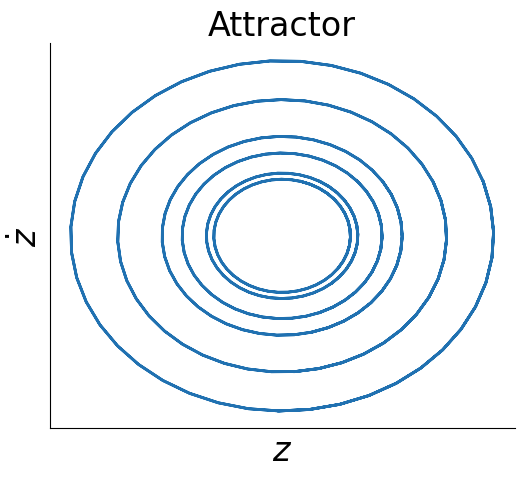

In [ ]:
t = np.arange(0, 20, 0.2)
z0s = np.pi / np.array([1.5, 2, 3, 4, 8, 16])
dz0s = 0.5 * np.ones(z0s.shape)

# set f such that it reflects the system you are trying to graph
# f = lambda z, t: [z[1], -0.5341*z[0]]
# f = lambda z, t: [z[1], 1]
n_ics = z0s.size

z = np.zeros((n_ics, t.size, 2))
dz = np.zeros(z.shape)
for i in range(n_ics):
    z[i] = odeint(f, [z0s[i], dz0s[i]], t)
    dz[i] = np.array([f(z[i, j], t[j]) for j in range(len(t))])

x, dx, ddx = pendulum_to_movie(z, dz)

test_data = {}
test_data["x"] = x.reshape((-1, params["input_dim"]))
test_data["dx"] = dx.reshape((-1, params["input_dim"]))
test_data["ddx"] = ddx.reshape((-1, params["input_dim"]))
test_data["z"] = z[:, :, 0].reshape((-1, params["latent_dim"]))
test_data["dz"] = z[:, :, 1].reshape((-1, params["latent_dim"]))
test_data["ddz"] = dz[:, :, 1].reshape((-1, params["latent_dim"]))


true_coefficients = np.zeros(sindy.sindy_coefficients.shape)
# Set the value of each coefficient to produce the attractor

z_sim = np.zeros((n_ics, t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)


for i in range(n_ics):
    pendulum_sim[i] = sindy_simulate_order2(
        test_data["z"][i * t.size],
        test_data["dz"][i * t.size],
        t,
        true_coefficients,
        params["poly_order"],
        params["include_sine"],
    )


# Plot true pendulum
plt.figure(figsize=(6, 5))
plt.plot(pendulum_sim[:, :, 0].T, pendulum_sim[:, :, 1].T, linewidth=2, color="#2071B1")
plt.xlabel(r"$z$", fontsize=24)
plt.ylabel(r"$\dot{z}$", fontsize=24, )
plt.title("Attractor", fontsize=24)

# Remove ticks
plt.xticks([])
plt.yticks([])

# Customize axes (spines)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("pendulum.png")
plt.show()
